[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [17]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the package

Import **multimin** and other required libraries:

In [18]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [19]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
# df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

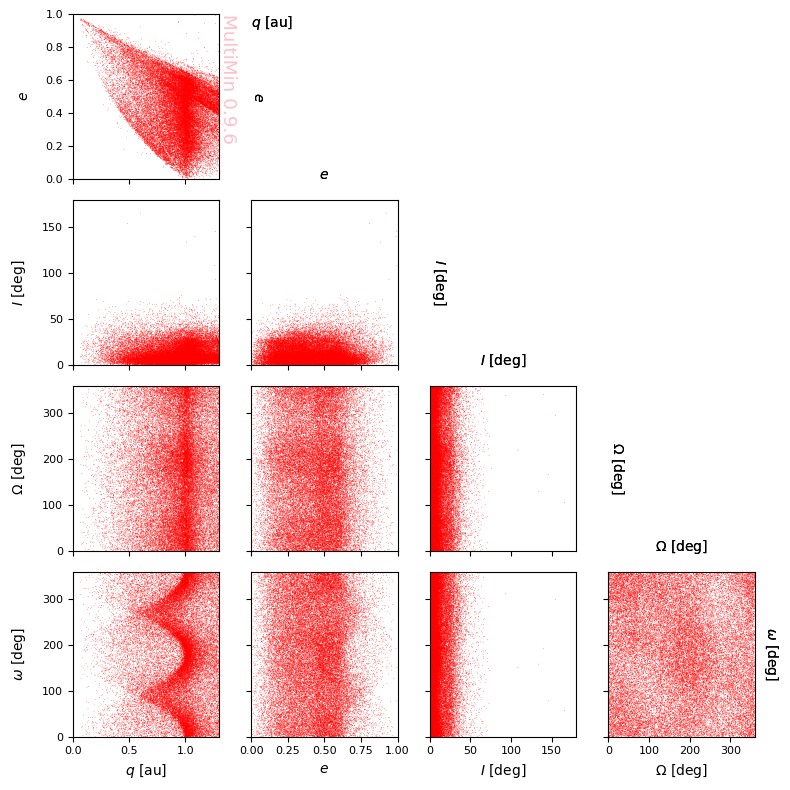

In [20]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


### Transforming data

In [21]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

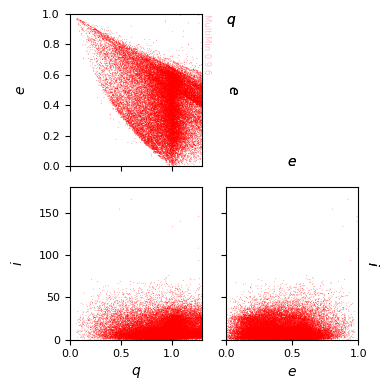

In [22]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [23]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

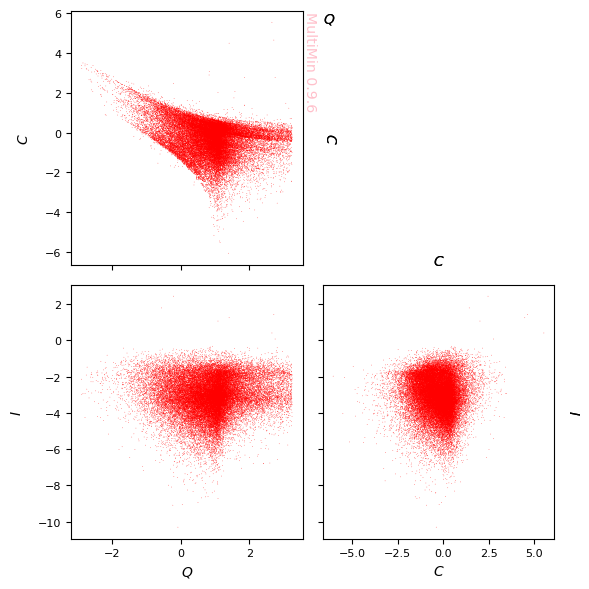

In [24]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


Create the fitter (e.g. one Gaussian, three variables):

In [25]:
F=mn.FitCMND(data=udata, ngauss=1)

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 40761
Log-likelihood per point (-log L/N): 13.953295353295578


Run the minimization:

In [32]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False, progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.norm_log_l()}")

Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 130.182 ms
-log(L)/N = 3.9688983005707215


Plot the fit result (fitted sample + data scatter):

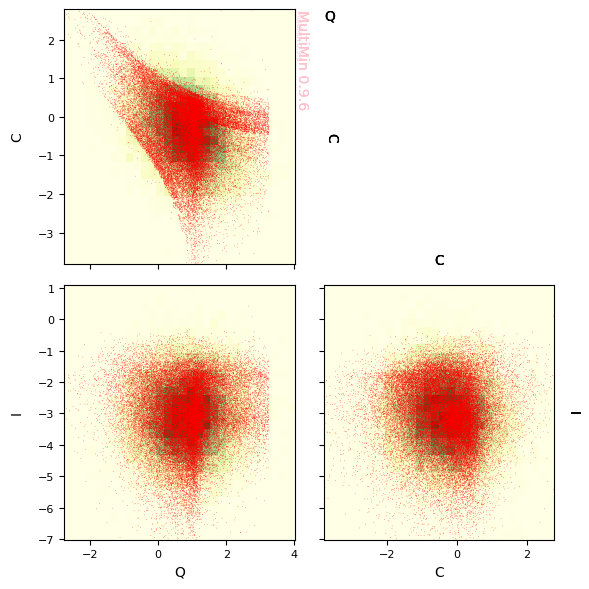

In [33]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


{'ks_dist': np.float64(0.04209218076102156),
 'r2_identity': np.float64(0.9263796861287901)}

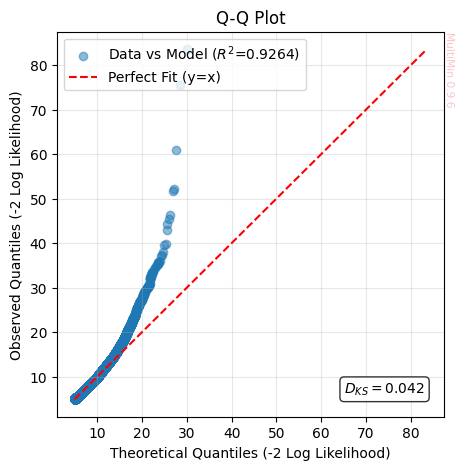

In [34]:
F.quality_of_fit(plot_qq=True, n_sim=50000)

Fitting with five Gaussians can capture more structure:

In [42]:
F=mn.FitCMND(data=udata, ngauss=20)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(bounds=bounds, progress="tqdm")
mn.Util.el_time()

Loading a FitCMND object.
Number of gaussians: 20
Number of variables: 3
Number of dimensions: 60
Number of samples: 40761
Log-likelihood per point (-log L/N): 13.953295353295578


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 3.82003 min


(229.2020800113678, [3.82003466685613, 'min'])

-log(L)/N = 3.648056946708326


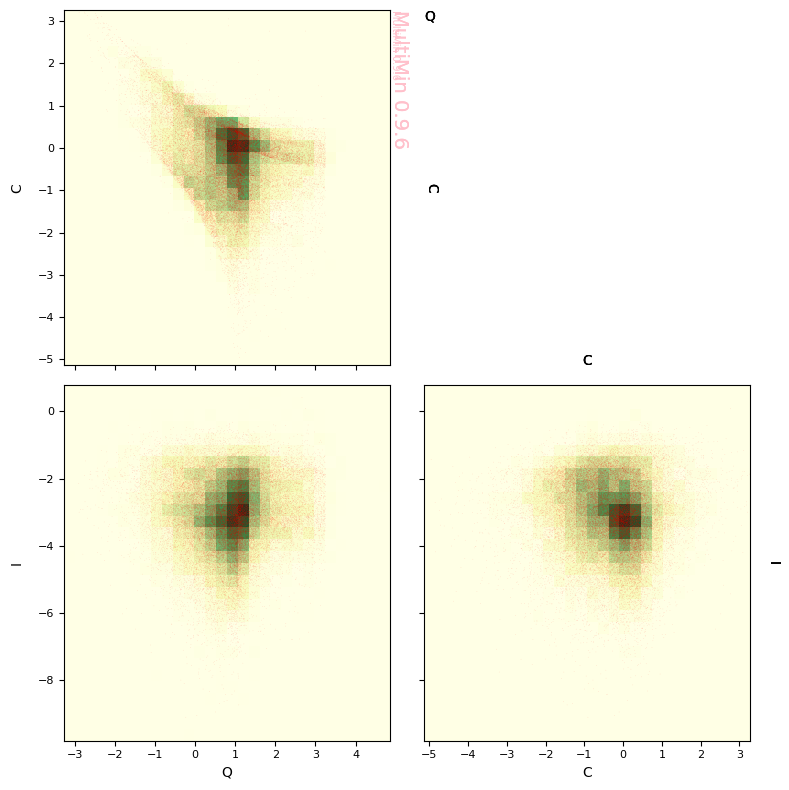

In [43]:
print(f"-log(L)/N = {F.norm_log_l()}")
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r',alpha=0.2))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

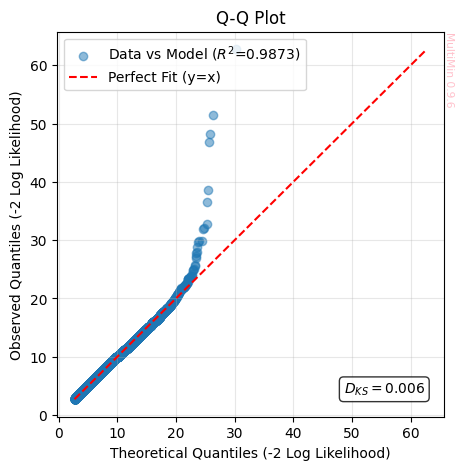

In [44]:
ks, R2 = F.quality_of_fit(plot_qq=True, n_sim=50000)

We can also check the original distribution:

In [45]:
scales=[1.35,1.00,180.0]
usample = F.cmnd.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

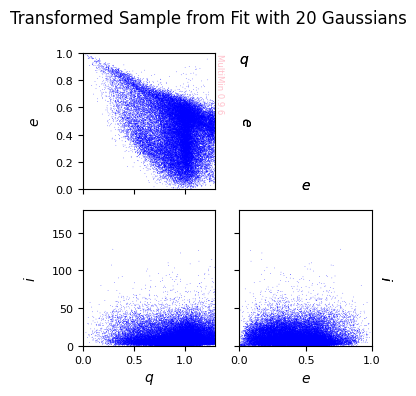

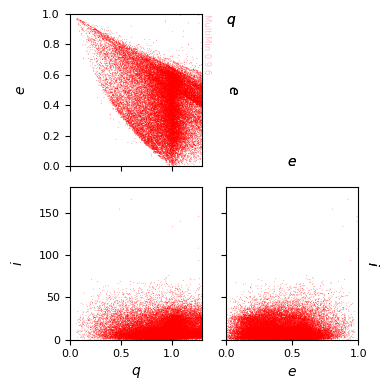

In [47]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=2)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=2)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [50]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_q = 1.371241
    mu1_e = 0.294089
    mu1_i = -2.491141
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.412029, -0.220073, 0.059309], [-0.220073, 0.141189, -0.008844], [0.059309, -0.008844, 0.452343]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_q = 2.707366
    mu2_e = -0.135946
    mu2_i = -3.069132
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.105895, -0.004446, 0.029796], [-0.004446, 0.072315, 0.072106], [0.029796, 0.072106, 0.598495]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_q = 0.915712
    mu3_e = -0.196871
    mu3_i = -3.06616
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.601953, -0.023818, -0.170873], [-0.023818, 0.068855, -0.115329], [-0.170873, -0.115329, 0.42672]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_q = 0.893091
    mu4_e = -0.357794
    mu4_i = -2.742915
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.075186, -0.077372, -0.04597], [-0.077372, 0.136458, 0.089382], [-0.04597, 0.089382, 0.711771]]
    n4 = nmd(X, mu4, Sigma4)

 

In [52]:
%timeit cmnd([0.5, 0.5, 20])

590 μs ± 27.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [59]:
F.save_fit(f"gallery/fit.pkl")

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga